[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238187-lesson-2-simple-graph)

# The Simplest Graph

Let's build a simple graph with 3 nodes and one conditional edge. 

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [3]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [4]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

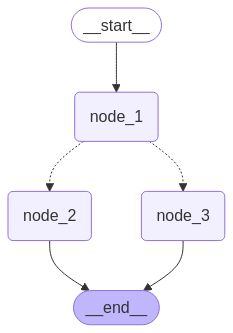

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [12]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

`invoke` runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it returns the state after `node_3` has completed: 

```
{'graph_state': 'Hi, this is Lance. I am sad!'}
```

# My exaples

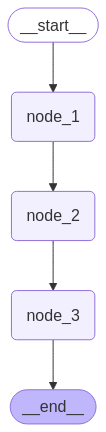

{'graph_output': 'I name is Lance'}

In [26]:
class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    graph_output: str

class OverallState(TypedDict):
    foo: str
    user_input: str
    graph_output: str

class PrivateState(TypedDict):
    bar: str

def node_1(state: InputState) -> OverallState:
    # Write to OverallState
    return {"foo": state["user_input"] + " name"}

def node_2(state: OverallState) -> PrivateState:
    # Read from OverallState, write to PrivateState
    return {"bar": state["foo"] + " is"}

def node_3(state: PrivateState) -> OutputState:
    # Read from PrivateState, write to OutputState
    return {"graph_output": state["bar"] + " Lance"}

builder = StateGraph(OverallState,input=InputState,output=OutputState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


graph.invoke({"user_input":"I"})
# {'graph_output': 'My name is Lance'}

In [27]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph

builder = StateGraph(dict)


def my_node(state: dict, config: RunnableConfig):
    print("In node: ", config["configurable"]["user_id"])
    return {"results": f"Hello, {state['input']}!"}


# The second argument is optional
def my_other_node(state: dict):
    return state


builder.add_node("my_node", my_node)
builder.add_node("other_node", my_other_node)
...

Ellipsis

## 1. calculator

### a

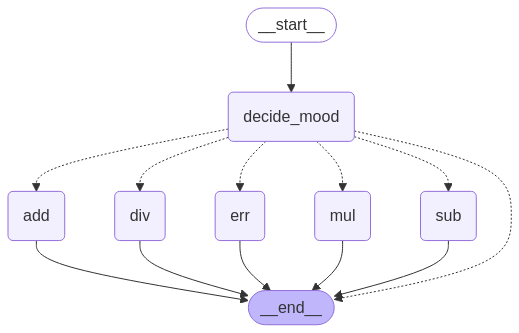

---Node 1 (ADD)---
the sum of 3, 5: 8
---Node 2 (SUB)---
the difference of 3, 5: -2
---Node 3 (MUL)---
the multiplication of 3, 5: 15
---Node 4 (DIV)---
the division of 10, 2: 5.0
---Node 5 (ERROR)---
Unable to process the expression.


In [42]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import display, Image

class State(TypedDict, total=False):
    graph_state: str
    next_node: str

def add(state):
    print("---Node 1 (ADD)---")
    try:
        val1, val2 = state['graph_state'].split(' + ')
        return {"graph_state": f"the sum of {val1}, {val2}: {int(val1) + int(val2)}"}
    except:
        return {"graph_state": state["graph_state"], "next_node": "err"}

def sub(state):
    print("---Node 2 (SUB)---")
    try:
        val1, val2 = state['graph_state'].split(' - ')
        return {"graph_state": f"the difference of {val1}, {val2}: {int(val1) - int(val2)}"}
    except:
        return {"graph_state": state["graph_state"], "next_node": "err"}

def mul(state):
    print("---Node 3 (MUL)---")
    try:
        val1, val2 = state['graph_state'].split(' * ')
        return {"graph_state": f"the multiplication of {val1}, {val2}: {int(val1) * int(val2)}"}
    except:
        return {"graph_state": state["graph_state"], "next_node": "err"}

def div(state):
    print("---Node 4 (DIV)---")
    try:
        val1, val2 = state['graph_state'].split(' / ')
        return {"graph_state": f"the division of {val1}, {val2}: {int(val1) / int(val2)}"}
    except:
        return {"graph_state": state["graph_state"], "next_node": "err"}

def err(state):
    print("---Node 5 (ERROR)---")
    return {"graph_state": "Unable to process the expression."}

def decide_mood(state):
    user_input = state['graph_state']
    if '+' in user_input:
        return {"graph_state": user_input, "next_node": "add"}
    elif '-' in user_input:
        return {"graph_state": user_input, "next_node": "sub"}
    elif '*' in user_input:
        return {"graph_state": user_input, "next_node": "mul"}
    elif '/' in user_input:
        return {"graph_state": user_input, "next_node": "div"}
    else:
        return {"graph_state": user_input, "next_node": "err"}

def router(state):
    return state["next_node"]

# Build the graph
builder = StateGraph(State)

builder.add_node("decide_mood", decide_mood)
builder.add_node("add", add)
builder.add_node("sub", sub)
builder.add_node("mul", mul)
builder.add_node("div", div)
builder.add_node("err", err)

builder.add_edge(START, "decide_mood")
builder.add_conditional_edges("decide_mood", router)
builder.add_edge("add", END)
builder.add_edge("sub", END)
builder.add_edge("mul", END)
builder.add_edge("div", END)
builder.add_edge("err", END)

graph = builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Run with valid and invalid input
print(graph.invoke({"graph_state": "3 + 5"})["graph_state"])
print(graph.invoke({"graph_state": "3 - 5"})["graph_state"])
print(graph.invoke({"graph_state": "3 * 5"})["graph_state"])
print(graph.invoke({"graph_state": "10 / 2"})["graph_state"])
print(graph.invoke({"graph_state": "7 9"})["graph_state"])  # Invalid input


### b

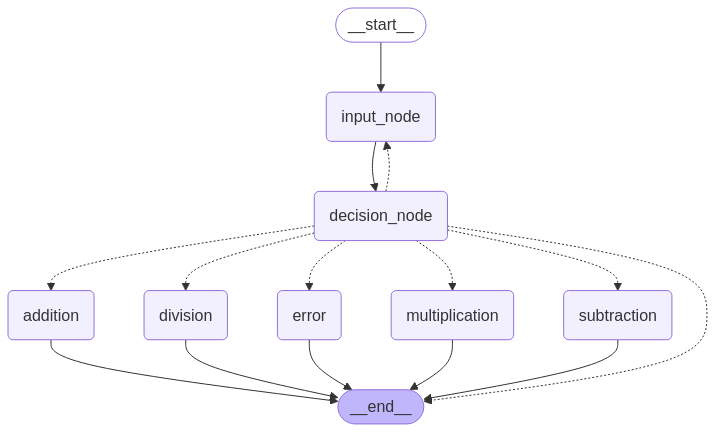

5.0


In [58]:
from typing import TypedDict, Union
from langgraph.graph import StateGraph, START, END

# 1) Define your shared State
class State(TypedDict, total=False):
    user_input: str
    operation: str
    result: Union[int, str]

# 2) Nodes

def input_node(state: State) -> State:
    # In real use you'd accept dynamic input; here we hard‑code for demo
    state["user_input"] = "10 / 2"
    return state

def decision_node(state: State) -> State:
    ui = state["user_input"]
    if "+" in ui:
        state["operation"] = "addition"
    elif "-" in ui:
        state["operation"] = "subtraction"
    elif "*" in ui:
        state["operation"] = "multiplication"
    elif "/" in ui:
        state["operation"] = "division"
    else:
        state["operation"] = "error"
    return state

def router(state: State) -> str:
    # returns the name of the next node
    return state["operation"]

def addition(state: State) -> State:
    a, b = map(int, state["user_input"].split(" + "))
    state["result"] = a + b
    return state

def subtraction(state: State) -> State:
    a, b = map(int, state["user_input"].split(" - "))
    state["result"] = a - b
    return state

def multiplication(state: State) -> State:
    a, b = map(int, state["user_input"].split(" * "))
    state["result"] = a * b
    return state

def division(state: State) -> State:
    a, b = map(int, state["user_input"].split(" / "))
    state["result"] = "Error: div by zero" if b == 0 else a / b
    return state

def error(state: State) -> State:
    state["result"] = "Invalid operation"
    return state

# 3) Build the graph

builder = StateGraph(State)

# register nodes
builder.add_node("input_node", input_node)
builder.add_node("decision_node", decision_node)
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)
builder.add_node("multiplication", multiplication)
builder.add_node("division", division)
builder.add_node("error", error)

# wire up edges
builder.add_edge(START, "input_node")
builder.add_edge("input_node", "decision_node")

# conditional routing
builder.add_conditional_edges("decision_node", router)

# terminal edges
builder.add_edge("addition", END)
builder.add_edge("subtraction", END)
builder.add_edge("multiplication", END)
builder.add_edge("division", END)
builder.add_edge("error", END)

# compile & run
graph = builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

output = graph.invoke({})  # no initial state needed; input_node sets it
print(output["result"])    # → 5.0


## 2. AREA


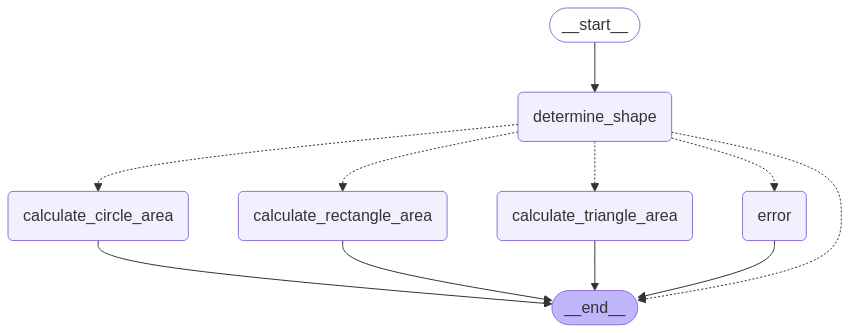

Area of the circle with radius 5: 78.53975
Area of the rectangle with length 4 and width 6: 24
Area of the triangle with height 4 and width 10: 20.0


{'shape': 'triangle', 'width': 10, 'height': 4}

In [54]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

# Define the state with optional fields for different shapes
class State(TypedDict, total=False):
    shape: str
    radius: float
    length: float
    width: float
    height: float

# Function to determine the shape and store its dimensions in the state
def determine_shape(state: State) -> State:
    user_input = state.get("shape", "").lower()
    if user_input == "circle":
        return {"shape": "circle", "radius": state.get("radius")}
    elif user_input == "rectangle":
        return {"shape": "rectangle", "length": state.get("length"), "width": state.get("width")}
    elif user_input == "triangle":
        return {"shape": "triangle", "height": state.get("height"), "width": state.get("width")}
    else:
        return {"shape": "unknown"}

# Function to calculate the area of a circle
def calculate_circle_area(state: State) -> State:
    radius = state.get("radius")
    if radius is not None:
        area = 3.14159 * radius ** 2
        print(f"Area of the circle with radius {radius}: {area}")
        return {"shape": "circle", "radius": radius}
    else:
        print("Invalid input for circle.")
        return {"shape": "error"}

# Function to calculate the area of a rectangle
def calculate_rectangle_area(state: State) -> State:
    length = state.get("length")
    width = state.get("width")
    if length is not None and width is not None:
        area = length * width
        print(f"Area of the rectangle with length {length} and width {width}: {area}")
        return {"shape": "rectangle", "length": length, "width": width}
    else:
        print("Invalid input for rectangle.")
        return {"shape": "error"}

# Function to calculate the area of a triangle
def calculate_triangle_area(state: State) -> State:
    height = state.get("height")
    width = state.get("width")
    if height is not None and width is not None:
        area = 0.5 * height * width
        print(f"Area of the triangle with height {height} and width {width}: {area}")
        return {"shape": "triangle", "height": height, "width": width}
    else:
        print("Invalid input for triangle.")
        return {"shape": "error"}

# Router function to direct to the appropriate calculation function
def router(state: State) -> str:
    shape = state.get("shape")
    if shape == "circle":
        return "calculate_circle_area"
    elif shape == "rectangle":
        return "calculate_rectangle_area"
    elif shape == "triangle":
        return "calculate_triangle_area"
    else:
        return "error"

# Build the graph
builder = StateGraph(State)
builder.add_node("determine_shape", determine_shape)
builder.add_node("calculate_circle_area", calculate_circle_area)
builder.add_node("calculate_rectangle_area", calculate_rectangle_area)
builder.add_node("calculate_triangle_area", calculate_triangle_area)
builder.add_node("error", lambda state: print("Error: Unknown shape or invalid dimensions."))

# Define the graph flow
builder.add_edge(START, "determine_shape")
builder.add_conditional_edges("determine_shape", router)
builder.add_edge("calculate_circle_area", END)
builder.add_edge("calculate_rectangle_area", END)
builder.add_edge("calculate_triangle_area", END)
builder.add_edge("error", END)

# Compile the graph
graph = builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Example invocation
# For a circle with radius 5
graph.invoke({"shape": "circle", "radius": 5})

# For a rectangle with length 4 and width 6
graph.invoke({"shape": "rectangle", "length": 4, "width": 6})

# For a triangle with height 4 and width 10
graph.invoke({"shape": "triangle", "height": 4, "width": 10})
